# 初始化

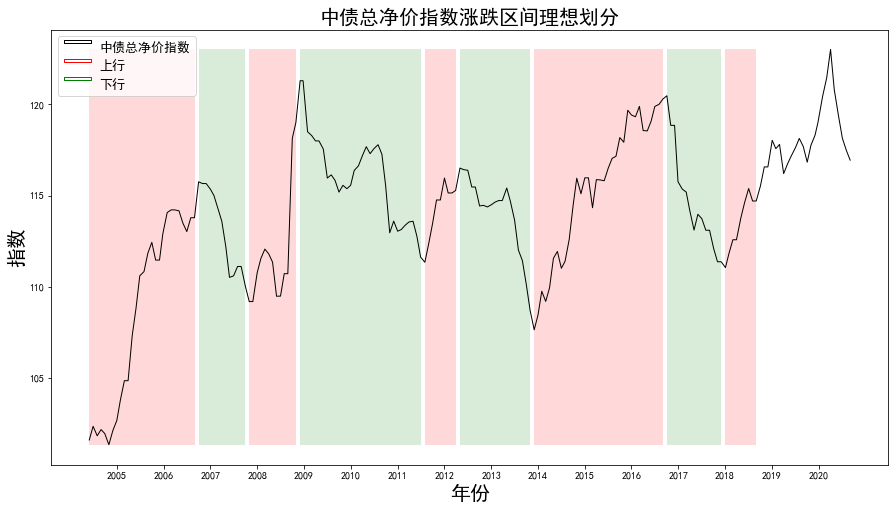

理想收益率 1.53


In [11]:
import plotly.graph_objects as go
import datetime
from datetime import datetime
import random
import calendar
import time
import tensorflow as tf

from subprocess import call
from scipy import signal
from sklearn import tree
import sklearn
from matplotlib.lines import Line2D
import statsmodels.tsa.stattools as ts
import matplotlib.ticker as mtick
import matplotlib.collections as collections
from numpy import linalg
from IPython.display import Image
import os
import graphviz
import sys
import csv
import pandas as pd 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import numpy as np
import warnings
from sklearn.tree import export_graphviz
from sklearn import datasets
warnings.filterwarnings("ignore")
import math
import operator
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager as fm
from sklearn import preprocessing
from sklearn import linear_model
from statsmodels.tsa.arima_model import ARIMA
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy import stats
from copy import deepcopy
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.feature_extraction import DictVectorizer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import cross_validate

from WindPy import w
w.start()
#趋势划分函数

def und(data, l1, l2):
    i = 0
    res = [0] * len(data)

    while i < len(data)-1:
        if i + l1 >= len(data) - 1 - l2:
            for j in range(i, len(data)-l2):
                res[j] = res[i]
            break
        cur = data[i]
        
        next_id = min([(data).index(max(data[i+1+l1:i+1+l2])), data.index(min(data[i+1+l1:i+1+l2]))])
        res[i:next_id+1] = [- (-1) ** (data[next_id] > data[i])] * (next_id + 1 - i)
        i = next_id
    return res

#清理重复的月份
def date_clean(date,data):
    date_res = [date[0]]
    data_res = [[i[0]] for i in data]
    
    last = date[0]
    
    for i in range(len(date[1:])):
        cur = date[i]
        if cur.month != last.month:
            date_res.append(cur)
            for j in range(len(data_res)):
                data_res[j].append(data[j][i])
        last = date[i]

    return date_res, data_res

#移动平均线MA
def ma(data, l_ma):
    res = []
    for i in range(l_ma-1,len(data)):
        res.append(np.mean(data[i-l_ma+1:i+1]))
    return res

#ROCSMA变化率移动平均
def rocsma(d1,i1,l_roc,l_sma):
    res = 0
    for x in range(l_sma):
        res += (d1[i1-x]/d1[i1-x-l_roc]-1)/l_sma
    return res

#KST公式
def kst(d2,roc_l1,roc_l2,roc_l3,roc_l4,sma_l1,sma_l2,sma_l3,sma_l4):
    res = []
    for i in range(roc_l4+sma_l4, len(d2)):
        rocma1 = rocsma(d2,i,roc_l1,sma_l1)
        rocma2 = rocsma(d2,i,roc_l2,sma_l2)
        rocma3 = rocsma(d2,i,roc_l3,sma_l3)
        rocma4 = rocsma(d2,i,roc_l4,sma_l4)
        res.append(rocma1 * 1 + rocma2 * 2 + rocma3 * 3 + rocma4 * 4)
    return res
    
#斜率
def slope(data):
    res = [0]
    for i in range(1,len(data)):
        res.append(-(-1) ** (data[i]>data[i-1]))
    res[0] = res[1]
    return res
    
#获取下个月末
def next_month(date):
    if date.month == 12:
        res = date.replace(year = date.year + 1, month = 1, day = calendar.monthrange(int(date.year+1), 1)[1])
        
    else:
        res = date.replace(month = date.month + 1, day = calendar.monthrange(int(date.year), date.month + 1)[1])
        
    return res

#相对强度
def rel_str(data, i1, i2):
    return (np.array(data[i1])/np.mean(data[i1])) / (np.array(data[i2])/np.mean(data[i2]))

#训练与验证集
def trvd(x, y, ratio):
    train_x = x[:int(len(x)*ratio)]
    valid_x = x[int(len(x)*ratio):]
    train_y = y[:int(len(x)*ratio)]
    valid_y = y[int(len(x)*ratio):]
    
    print(len(train_x), len(valid_x), len(train_y), len(valid_y))
    return train_x, valid_x, train_y, valid_y

#交叉变换趋势
def cross(d1,d2,cd):
    comp = [-(-1) ** (d1[i] > d2[i]) for i in range(len(d1))]
    res = [-comp[0]]
    c = 0
    
    for i in range(1,len(comp)):
        if comp[i] * comp[i-1] == -1 and c == 0:
            sl1 = -(-1)**(d1[i]>d1[i-1])
            sl2 = -(-1)**(d2[i]>d2[i-1])
            res.append(sl1*sl2)
            c += cd
        else:
            res.append(res[-1])
            c = max(0,c-1)
    return res

#大小对比
def comp(d1,d2):
    res = [-(-1) ** (d1[i] > d2[i]) for i in range(len(d1))]
    return res

#标准化
def std(data):
    res = []
    for i in range(len(data)):
        res.append((data[i] - np.mean(data[:i+1]))/np.mean(data[:i+1]))
    return res

#普林格经济周期
def pring(b,s,c):
    if b == 1 and s == c == -1:
        return -3
    if b == s == 1 and c == -1:
        return -1
    if b == s == c == 1:
        return 1
    if b == -1 and s == c == 1:
        return 3
    if b == s == -1 and c == 1:
        return 1
    if b == s == c == -1:
        return -1
    else:
        return 0

def dupe_legend(label, color):
    line = Line2D([0], [0], linestyle='none', mfc= 'white',
                mec=color, marker=r'$\mathregular{{{}}}$'.format(label))
    return line

#平滑折线
def smooth(data):
    for i in range(len(data)-4):
        if data[i] * data[i+2] == 1 and data[i] * data[i+1] == -1:
            data[i+1] = data[i]
        elif data[i] * data[i+3] == 1 and all(data[i+1:i+3]) != data[i]:
            for j in range(2):
                data[i+j+1] = data[i]
        elif data[i] * data[i+4] == 1 and all(data[i+1:i+4]) != data[i]:
            for j in range(3):
                data[i+j+1] = data[i]
    return data

def data_pro(data,l,std_id):
    df = []
    #从第l个周期开始
    for i in range(l-1,len(date)):
        temp = []

        for j in range(len(data)):
            i = int(i)
            j = int(j)
            #选取第j组第i+l时间点前l长度的数据
            il = data[j][i-l+1:i+1]

            #第i+l时间点前l长度的涨跌幅度及方向————0
            temp.append(il[-1]/il[0]-1)

            #第i+l时间点前l长度内的最大波动幅度————1
            temp.append(((max(il)-min(il))/np.mean(il)))

            #第i+l时间点前l长度内的反转频率————2
            spike = 0
            dirc = -(-1) ** (il[1] > il[0]) 
            for k in range(1,l):
                spike += (-(-1) ** (il[k] > il[k-1]) != dirc)
                dirc = -(-1) ** (il[k] > il[k-1])
            temp.append(spike/l)

            if std_id == 1:
                #第i+l时间点l个时长的移动平均值，并根据之前的平均值标准化————3
                temp.append(np.mean(il)/np.mean(data[j][:i])-1)    

                #第i+l时间点的数据，并根据之前的平均值标准化————4
                temp.append(data[j][i]/np.mean(data[j][:i])-1)
                
                #第i+l时间点6个时长的移动平均值，并根据之前的平均值标准化————5
                il = data[j][i-6+1:i+1]
                temp.append(np.mean(il)/np.mean(data[j][:i])-1)    
                
                #第i+l时间点9个时长的移动平均值，并根据之前的平均值标准化————6
                il = data[j][i-9+1:i+1]
                temp.append(np.mean(il)/np.mean(data[j][:i])-1)    

            else:

                #第i+l时间点l个时长的移动平均值————3
                temp.append(np.mean(il))    

                #第i+l时间点的数据————4
                temp.append(data[j][i])

                #第i+l时间点l个时长的移动平均值————5
                il = data[j][i-6+1:i+1]
                temp.append(np.mean(il))    

                #第i+l时间点l个时长的移动平均值————6
                il = data[j][i-9+1:i+1]
                temp.append(np.mean(il))                    
        df.append(temp)
    return df

def smooth2(data):
    for i in range(len(data)-5):
        if data[i] * data[i+5] == 1 and all(data[i+1:i+4]) != data[i]:
            for j in range(4):
                data[i+j+1] = data[i]
    return data
    
def date2num(date):
    d8 = []
    for i in range(len(date)):
        d8.append(int((date[i] - date[0]).days))
    return d8
    
def find1y(date):
    last = date[0]
    for i in range(len(date)):
        cur = date[i]
        if cur.year != last.year:
            return i
        last = date[i]
######################################评估方式

#准确度计算
def acc(d1,d2):
    return round(sum(np.array(d1) == np.array(d2))/ len(d1),3)

#收益率计算
def profit(data, ud):
    money = 1
    num = 0
    prt = 0   #显示买卖记录
    for i in range(len(data)):
        if ud[i] == 1 and num == 0:
            if prt:
                print('in', date[11:][i], 'money', money, 'num', num, 'price', data[i])
            num = money/data[i]
            money = 0
        if ud[i] != 1 and money == 0:
            if prt:
                print('out', date[11:][i], 'money', money, 'num', num, 'price', data[i])
            money = num * data[i]
            num = 0
    if prt:
        print('结果',max(money,num*data[-1]))
    return max(money,num*data[-1])

#复杂度计算
def cpx(x):
    res = 1
    dirc = x[0]
    for i in range(len(x)):
        if x[i] != dirc:
            res += 1
            dirc = x[i]
    return res/len(x)


def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = pd.ewma(timeSeries, span=size)

    timeSeries.plot(color='blue', label='Original')
    rolmean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()

'''
　　Unit Root Test
   The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
   root, with the alternative that there is no unit root. That is to say the
   bigger the p-value the more reason we assert that there is a unit root
'''
def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

# 自相关和偏相关图，默认阶数为31阶
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()
    
def tsplot(y, lags=None, figsize=(10,8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):#定义局部样式
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)#自相关系数ACF图
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)#偏相关系数PACF图
        sm.qqplot(y, line='s', ax=qq_ax)#QQ图检验是否是正太分布
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return
    
    
int_list = [['M0020188','股票'],['S0105896','商品'],['M0265832','中债总净价指数'],['G1000116','OECD'],['M0043815','短贷利率']]

#起止时间
t0 = '2004-06-01'
t1 = '2020-10-01'

#指数取值周期
dic = {'D':'天', 'W':'周', 'M':'月', 'Q':'季度', 'S':'半年', 'Y':'年'}
prd = 'M'

#移动平均线平均时长
l = 12

ind_list = []
for i in int_list:
    ind_list.append(i[0])
    
og = w.wsd(ind_list, 'close', t0, '-1D', Period = prd, Fill = 'Previous')

#训练比例
r = .5

#指数与日期
date, data = date_clean(og.Times, og.Data)
date_s = [str(i) for i in date]

df = []
d8 = date2num(date)
################################    

ud = und(data[2],6,24)
base_cpx = cpx(ud)
    
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('中债总净价指数涨跌区间理想划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[2], color='black', linewidth = 1, label = '中债总净价指数')

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8, ymin=min(data[2]), ymax=max(data[2]), where=np.array(ud) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8, ymin=min(data[2]), ymax=max(data[2]), where=np.array(ud) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)


_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()
print('理想收益率',round(profit(data[2][:-24],ud[:-24]),3))
####################
df = data_pro(data, l, 1)

# 神经网络

In [100]:
#激活函数及坡度
def sig(x):
    return 1 / (1 + exp(-x))

def sig_drv(x):
    return x * (1-x)

def gen_layer(num_input, num_nur):
    res = []
    for i in range(len(num_nur)):
        res.append(2 * random.random((num_input[i], num_nur[i])) - 1)
    return res

def calc(x, nn, y):
    start = 1
    for i in range(len(nn)):
        if start == 1:
            start = 0
            res = sig(dot(x, nn[i]))
        else:
            res = sig(dot(res, nn[i]))
    return res

def correct(ans, aim, step):
    for i in range(len(nn)-1,0,-1):
        if i == len(nn)-1:
            dif = (ans - aim)
            move = dif * sig_drv(res)
        else:
            movd = dif * sig_drv()

In [99]:
x = array([[0, 0, 1], [0, 1, 1], [1, 0, 1], [0, 1, 0], [1, 0, 0], [1, 1, 1], [0, 0, 0]])
y = array([[0, 1, 1, 1, 1, 0, 0]]).T
a = [3,4]
b = [4,1]
n = gen_layer(a,b)
correct(calc(x,n,y), y)


array([[ 0.48444946],
       [-0.5008608 ],
       [-0.51849114],
       [-0.44958935],
       [-0.46305724],
       [ 0.49683505],
       [ 0.54049114]])

In [54]:
from numpy import exp, array, random, dot

class NeuronLayer():
    def __init__(self, number_of_neurons, number_of_inputs_per_neuron):
        self.synaptic_weights = 2 * random.random((number_of_inputs_per_neuron, number_of_neurons)) - 1
        
class NeuralNetwork():
    def __init__(self, layer1, layer2):
        self.layer1 = layer1
        self.layer2 = layer2

    # The Sigmoid function, which describes an S shaped curve.
    # We pass the weighted sum of the inputs through this function to
    # normalise them between 0 and 1.
    def __sigmoid(self, x):
        return 1 / (1 + exp(-x))

    # The derivative of the Sigmoid function.
    # This is the gradient of the Sigmoid curve.
    # It indicates how confident we are about the existing weight.
    def __sigmoid_derivative(self, x):
        return x * (1 - x)

    def prelu(self,x):
        return np.where(x<0, 0.5*x, x)
    
    def prelu_der(self,x):
        return np.where(x<0,0.5,1)
    
    # We train the neural network through a process of trial and error.
    # Adjusting the synaptic weights each time.
    def train(self, training_set_inputs, training_set_outputs, number_of_training_iterations):
        for iteration in range(number_of_training_iterations):
            # Pass the training set through our neural network
            output_from_layer_1, output_from_layer_2 = self.think(training_set_inputs)

            # Calculate the error for layer 2 (The difference between the desired output
            # and the predicted output).
            layer2_error = training_set_outputs - output_from_layer_2
            layer2_delta = layer2_error * self.__sigmoid_derivative(output_from_layer_2)

            # Calculate the error for layer 1 (By looking at the weights in layer 1,
            # we can determine by how much layer 1 contributed to the error in layer 2).
            layer1_error = layer2_delta.dot(self.layer2.synaptic_weights.T)
            layer1_delta = layer1_error * self.__sigmoid_derivative(output_from_layer_1)

            # Calculate how much to adjust the weights by
            layer1_adjustment = training_set_inputs.T.dot(layer1_delta)
            layer2_adjustment = output_from_layer_1.T.dot(layer2_delta)

            # Adjust the weights.
            self.layer1.synaptic_weights += layer1_adjustment
            self.layer2.synaptic_weights += layer2_adjustment

    # The neural network thinks.
    def think(self, inputs):
        output_from_layer1 = self.__sigmoid(dot(inputs, self.layer1.synaptic_weights))
        output_from_layer2 = self.__sigmoid(dot(output_from_layer1, self.layer2.synaptic_weights))
        return output_from_layer1, output_from_layer2

    # The neural network prints its weights
    def print_weights(self):
        print("    Layer 1 (4 neurons, each with 3 inputs):")
        print(self.layer1.synaptic_weights)
        print("    Layer 2 (1 neuron, with 4 inputs):")
        print(self.layer2.synaptic_weights)

if __name__ == "__main__":

    #Seed the random number generator
    random.seed(1)

    # Create layer 1 (4 neurons, each with 3 inputs)
    layer1 = NeuronLayer(161, 7)

    # Create layer 2 (a single neuron with 4 inputs)
    layer2 = NeuronLayer(1, 161)

    # Combine the layers to create a neural network
    neural_network = NeuralNetwork(layer1, layer2)

    print("Stage 1) Random starting synaptic weights: ")
    neural_network.print_weights()

    # The training set. We have 7 examples, each consisting of 3 input values
    # and 1 output value.
    training_set_inputs = np.array([i[14:21] for i in df][:-24])
    training_set_outputs = np.array([[i] for i in ud[11:-24]])

    # Train the neural network using the training set.
    # Do it 60,000 times and make small adjustments each time.
    neural_network.train(training_set_inputs, training_set_outputs, 60000)

    print("Stage 2) New synaptic weights after training: ")
    neural_network.print_weights()

    # Test the neural network with a new situation.
    print("Stage 3) Considering a new situation [1, 1, 0] -> ?: ")
    hidden_state, output = neural_network.think([i[14:21] for i in df][-24:])
    print(output)

Stage 1) Random starting synaptic weights: 
    Layer 1 (4 neurons, each with 3 inputs):
[[-0.16595599  0.44064899 -0.99977125 ...  0.94003998  0.6936576
  -0.52030448]
 [-0.01246057  0.23991144  0.6579618  ...  0.70334375 -0.16830256
   0.23337013]
 [-0.53266772 -0.79606548  0.03171403 ... -0.34802038  0.71897864
   0.1170331 ]
 ...
 [-0.01176747 -0.73567772 -0.58709188 ...  0.17069692  0.79641009
  -0.10776556]
 [ 0.84373661 -0.44201822  0.21766235 ...  0.83651718 -0.92054259
  -0.85933312]
 [-0.05198742 -0.30166517  0.87450412 ... -0.41324744  0.85789892
   0.01423885]]
    Layer 2 (1 neuron, with 4 inputs):
[[-0.09061554]
 [ 0.17574301]
 [-0.47172471]
 [-0.3894234 ]
 [-0.25669085]
 [-0.511104  ]
 [ 0.16909453]
 [ 0.39169227]
 [-0.85610556]
 [ 0.94216664]
 [ 0.50614131]
 [ 0.61232633]
 [ 0.50328081]
 [-0.83987805]
 [-0.03660743]
 [-0.10865409]
 [ 0.3449453 ]
 [-0.10252548]
 [ 0.4086268 ]
 [ 0.36329068]
 [ 0.39429706]
 [ 0.23720149]
 [-0.69803853]
 [ 0.52160491]
 [ 0.56209164]
 [ 0.8

In [61]:
from numpy import exp, array, random, dot


class NeuronLayer():
    def __init__(self, number_of_neurons, number_of_inputs_per_neuron):
        self.synaptic_weights = 2 * random.random((number_of_inputs_per_neuron, number_of_neurons)) - 1


class NeuralNetwork():
    def __init__(self, layer1, layer2):
        self.layer1 = layer1
        self.layer2 = layer2

    # The Sigmoid function, which describes an S shaped curve.
    # We pass the weighted sum of the inputs through this function to
    # normalise them between 0 and 1.
    def __sigmoid(self, x):
        return 1 / (1 + exp(-x))

    # The derivative of the Sigmoid function.
    # This is the gradient of the Sigmoid curve.
    # It indicates how confident we are about the existing weight.
    def __sigmoid_derivative(self, x):
        return x * (1 - x)

    # We train the neural network through a process of trial and error.
    # Adjusting the synaptic weights each time.
    def train(self, training_set_inputs, training_set_outputs, number_of_training_iterations):
        for iteration in range(number_of_training_iterations):
            # Pass the training set through our neural network
            output_from_layer_1, output_from_layer_2 = self.think(training_set_inputs)

            # Calculate the error for layer 2 (The difference between the desired output
            # and the predicted output).
            layer2_error = training_set_outputs - output_from_layer_2
            layer2_delta = layer2_error * self.__sigmoid_derivative(output_from_layer_2)

            # Calculate the error for layer 1 (By looking at the weights in layer 1,
            # we can determine by how much layer 1 contributed to the error in layer 2).
            layer1_error = layer2_delta.dot(self.layer2.synaptic_weights.T)
            layer1_delta = layer1_error * self.__sigmoid_derivative(output_from_layer_1)

            # Calculate how much to adjust the weights by
            layer1_adjustment = training_set_inputs.T.dot(layer1_delta)
            layer2_adjustment = output_from_layer_1.T.dot(layer2_delta)

            # Adjust the weights.
            self.layer1.synaptic_weights += layer1_adjustment
            self.layer2.synaptic_weights += layer2_adjustment

    # The neural network thinks.
    def think(self, inputs):
        output_from_layer1 = self.__sigmoid(dot(inputs, self.layer1.synaptic_weights))
        output_from_layer2 = self.__sigmoid(dot(output_from_layer1, self.layer2.synaptic_weights))
        return output_from_layer1, output_from_layer2

    # The neural network prints its weights
    def print_weights(self):
        print("    Layer 1 (4 neurons, each with 3 inputs):")
        print(self.layer1.synaptic_weights)
        print("    Layer 2 (1 neuron, with 4 inputs):")
        print(self.layer2.synaptic_weights)

if __name__ == "__main__":

    #Seed the random number generator
    random.seed(1)

    # Create layer 1 (4 neurons, each with 3 inputs)
    layer1 = NeuronLayer(4, 3)

    # Create layer 2 (a single neuron with 4 inputs)
    layer2 = NeuronLayer(1, 4)

    # Combine the layers to create a neural network
    neural_network = NeuralNetwork(layer1, layer2)

    print("Stage 1) Random starting synaptic weights: ")
    neural_network.print_weights()

    # The training set. We have 7 examples, each consisting of 3 input values
    # and 1 output value.
    training_set_inputs = array([[0, 0, 1], [0, 1, 1], [1, 0, 1], [0, 1, 0], [1, 0, 0], [1, 1, 1], [0, 0, 0]])
    training_set_outputs = array([[0, 1, 1, 1, 1, 0, 0]]).T

    # Train the neural network using the training set.
    # Do it 60,000 times and make small adjustments each time.
    neural_network.train(training_set_inputs, training_set_outputs, 60000)

    print("Stage 2) New synaptic weights after training: ")
    neural_network.print_weights()

    # Test the neural network with a new situation.
    print("Stage 3) Considering a new situation [1, 1, 0] -> ?: ")
    hidden_state, output = neural_network.think(array([1, 1, 0]))
    print(output)

Stage 1) Random starting synaptic weights: 
    Layer 1 (4 neurons, each with 3 inputs):
[[-0.16595599  0.44064899 -0.99977125 -0.39533485]
 [-0.70648822 -0.81532281 -0.62747958 -0.30887855]
 [-0.20646505  0.07763347 -0.16161097  0.370439  ]]
    Layer 2 (1 neuron, with 4 inputs):
[[-0.5910955 ]
 [ 0.75623487]
 [-0.94522481]
 [ 0.34093502]]
Stage 2) New synaptic weights after training: 
    Layer 1 (4 neurons, each with 3 inputs):
[[ 0.3122465   4.57704063 -6.15329916 -8.75834924]
 [ 0.19676933 -8.74975548 -6.1638187   4.40720501]
 [-0.03327074 -0.58272995  0.08319184 -0.39787635]]
    Layer 2 (1 neuron, with 4 inputs):
[[ -8.18850925]
 [ 10.13210706]
 [-21.33532796]
 [  9.90935111]]
Stage 3) Considering a new situation [1, 1, 0] -> ?: 
[0.0078876]
